In [1]:
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
  
forest_fires = fetch_ucirepo(id=162)   
X = forest_fires.data.features
y = forest_fires.data.targets.values

label_encoder = LabelEncoder()  
X['month'] = label_encoder.fit_transform(X['month'])
X['day'] = label_encoder.fit_transform(X['day'])

scaler = StandardScaler()
X = scaler.fit_transform(X)

C:\Users\kopan\AppData\Local\Temp\ipykernel_19872\2957216850.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['month'] = label_encoder.fit_transform(X['month'])
C:\Users\kopan\AppData\Local\Temp\ipykernel_19872\2957216850.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['day'] = label_encoder.fit_transform(X['day'])


In [37]:
from sklearn.model_selection import train_test_split
import torch
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [38]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64) 
        self.fc2 = nn.Linear(64, 32)         
        self.fc3 = nn.Linear(32, 1)        
        self.relu = nn.ReLU()                 
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [39]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_mlp(model, X_train, y_train, epochs=2000, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    losses = []

    for epoch in tqdm(range(epochs), desc="Training MLP"):
        model.train()
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    plt.plot(range(epochs), losses, label="MLP Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print(f"Final Loss: {losses[-1]}")
    
    return losses

In [40]:
import torch.optim as optim

input_size = X_train.shape[1]
model = MLP(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training MLP: 100%|███████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 775.02it/s]


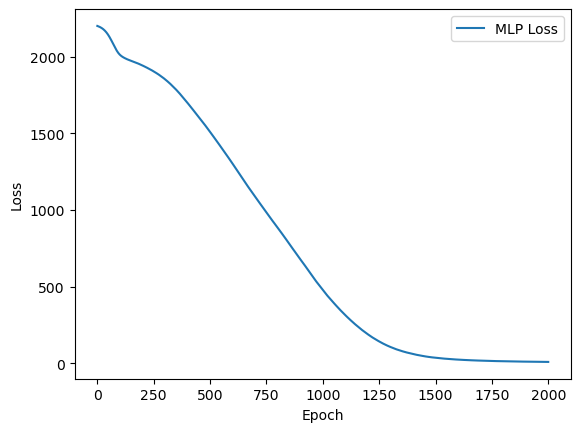

Final Loss: 9.01611614227295


In [41]:
input_size = X_train.shape[1]
model = MLP(input_size)

losses = train_mlp(model, X_train, y_train)

In [42]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    test_loss = criterion(y_test_pred, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

n = 10
print([round(float(_[0]), 2) for _ in y_test_pred[:n]])
print([round(float(_[0]), 2) for _ in y_test[:n]])

Test Loss: 16867.7715
[80.51, 1.12, 6.05, 19.08, 20.23, -18.21, 53.64, -21.97, -2.26, -2.36]
[0.0, 0.0, 1.23, 1.46, 1.95, 0.0, 13.99, 6.44, 0.0, 0.75]


In [43]:
class Autoencoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(input_size, hidden_size)
        self.decoder = nn.Linear(hidden_size, input_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        encoded = self.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded

In [44]:
def train_autoencoder(autoencoder, data, epochs=100, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
    losses = []
    for epoch in tqdm(range(epochs), desc="Training Autoencoder"):
        optimizer.zero_grad()
        output = autoencoder(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    plt.plot(range(epochs), losses, label="Autoencoder Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return autoencoder.encoder.weight.detach(), autoencoder.encoder.bias.detach()

In [45]:
def layerwise_training(data, model):
    autoencoder1 = Autoencoder(input_size=data.shape[1], hidden_size=64)
    weight1, bias1 = train_autoencoder(autoencoder1, data)
    model.fc1.weight.data = weight1
    model.fc1.bias.data = bias1
    with torch.no_grad():
        data_transformed = model.relu(model.fc1(data))
    autoencoder2 = Autoencoder(input_size=64, hidden_size=32)
    weight2, bias2 = train_autoencoder(autoencoder2, data_transformed)
    model.fc2.weight.data = weight2
    model.fc2.bias.data = bias2
    return model

Training Autoencoder: 100%|████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1136.14it/s]


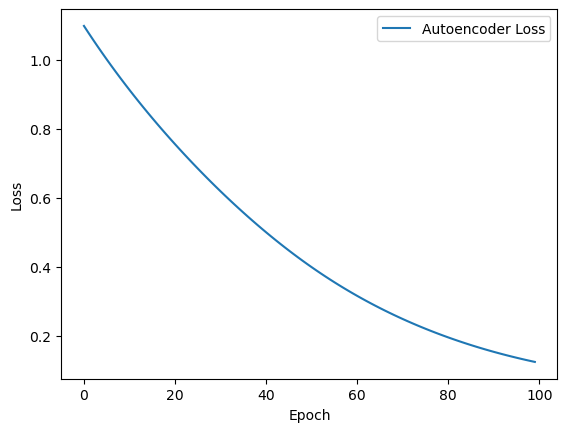

Training Autoencoder: 100%|████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1136.15it/s]


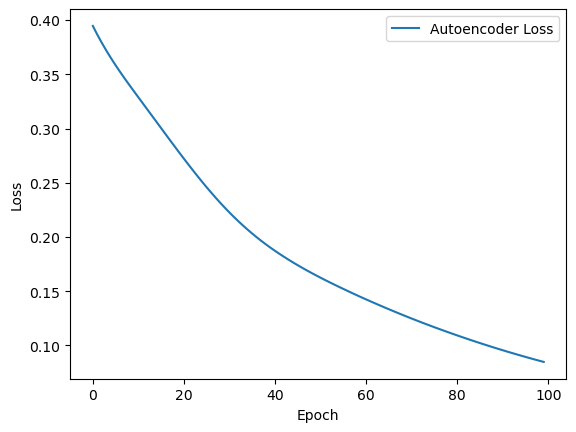

Training MLP: 100%|███████████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 838.03it/s]


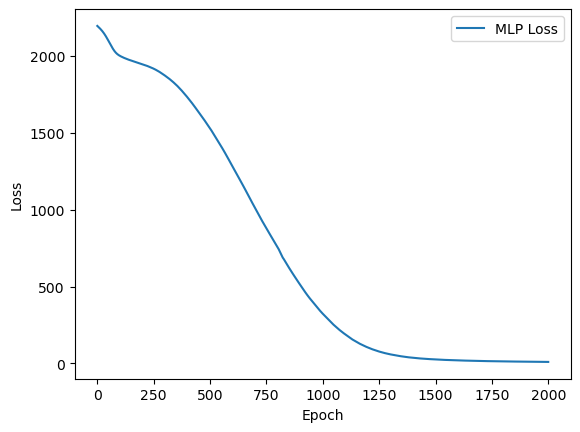

Final Loss: 9.881139755249023


In [46]:
import torch.optim as optim

input_size = X_train.shape[1]
model = MLP(input_size)
model = layerwise_training(X_train, model)

losses_pretr = train_mlp(model, X_train, y_train)

In [47]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    test_loss = criterion(y_test_pred, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

n = 10
print([round(float(_[0]), 2) for _ in y_test_pred[:n]])
print([round(float(_[0]), 2) for _ in y_test[:n]])

Test Loss: 15607.2988
[3.87, 13.76, 4.84, 24.34, -6.87, -3.63, 2.55, -17.35, 10.05, 0.22]
[0.0, 0.0, 1.23, 1.46, 1.95, 0.0, 13.99, 6.44, 0.0, 0.75]


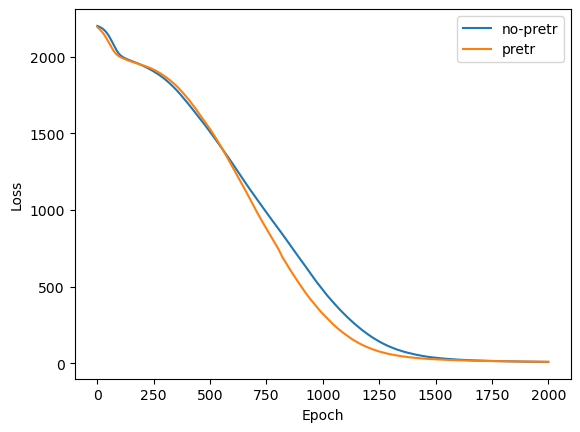

In [48]:
# Визуализация обучения
plt.plot(losses, label="no-pretr")
plt.plot(losses_pretr, label="pretr")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()